# Randoms

Here I compute the randoms for the mock catalogs.

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [26]:
#!/usr/bin/env python
import os
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

In [27]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [28]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

from scipy.interpolate import InterpolatedUnivariateSpline
plt.style.use(style.notebook)

In [29]:
import skymapper as skm

def plot_hpx_density(ra,dec, Npoints=10000, title=''):
    ix = np.random.randint(ra.size, size=Npoints)
    crit = skm.stdDistortion
    proj = skm.Albers.optimize(ra[ix], dec[ix], crit=crit)

    # construct map: will hold figure and projection
    # the outline of the sphere can be styled with kwargs for matplotlib Polygon
    map = skm.Map(proj)

    # add graticules, separated by 15 deg
    # the lines can be styled with kwargs for matplotlib Line2D
    # additional arguments for formatting the graticule labels
    sep=15
    map.grid(sep=sep)

    #### 1. plot density in healpix cells ####
    nside = 32
    mappable = map.density(ra, dec, nside=nside)
    cb = map.colorbar(mappable, cb_label="$n$ [arcmin$^{-2}$]")
    map.focus(ra[ix], dec[ix])
    map.title(title)
# example
# ra,dec = data['ra'],data['dec']
# plot_hpx_density(ra,dec)

In [30]:
import healpy as hp
def radec_to_pix(ra,dec,nside=4):
    thetas,phis = np.radians(90-dec),np.radians(ra)
    return hp.ang2pix(nside, thetas, phis,nest=False)

def makeHealpixMap(ra, dec, nside=1024, nest=False):
    # convert a ra/dec catalog into healpix map with counts per cell
    import healpy as hp
    ipix = hp.ang2pix(nside, (90-dec)/180*np.pi, ra/180*np.pi, nest=nest)
    return np.bincount(ipix, minlength=hp.nside2npix(nside))

In [31]:
# specify our cosmology
cosmo = cosmology.Cosmology(h=0.7).match(Omega0_m=0.3)


## Load Mock

In [32]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_nbody_fname)
data = FITSCatalog(floc.mock_nbody_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_nbody.fits


In [33]:
# mock['redshift']

In [34]:
import os
from astropy.table import Table
from astropy.io.fits import getdata

if not os.path.isfile(floc.mock_nbody_fname):
    mock = Table(getdata(floc.mock_fname))
    data = Table(mock[['RA','DEC','redshift','lambda_mor']])
    
    data.rename_columns(['RA','DEC','redshift'], ['ra','dec','z'])
    
    select_good = (data['z']>=0.2) & (data['z']<=0.65)
    select_good = select_good & ((data['z'] < 0.33)|(data['z'] > 0.37))
    select_good&= data['lambda_mor']>=5.
    ra = data['ra']
    ix, = np.where(ra<0); ra[ix] = ra[ix]+360
    data['ra'] = ra

    data = data[select_good]
    data.write(floc.mock_nbody_fname, overwrite=True)

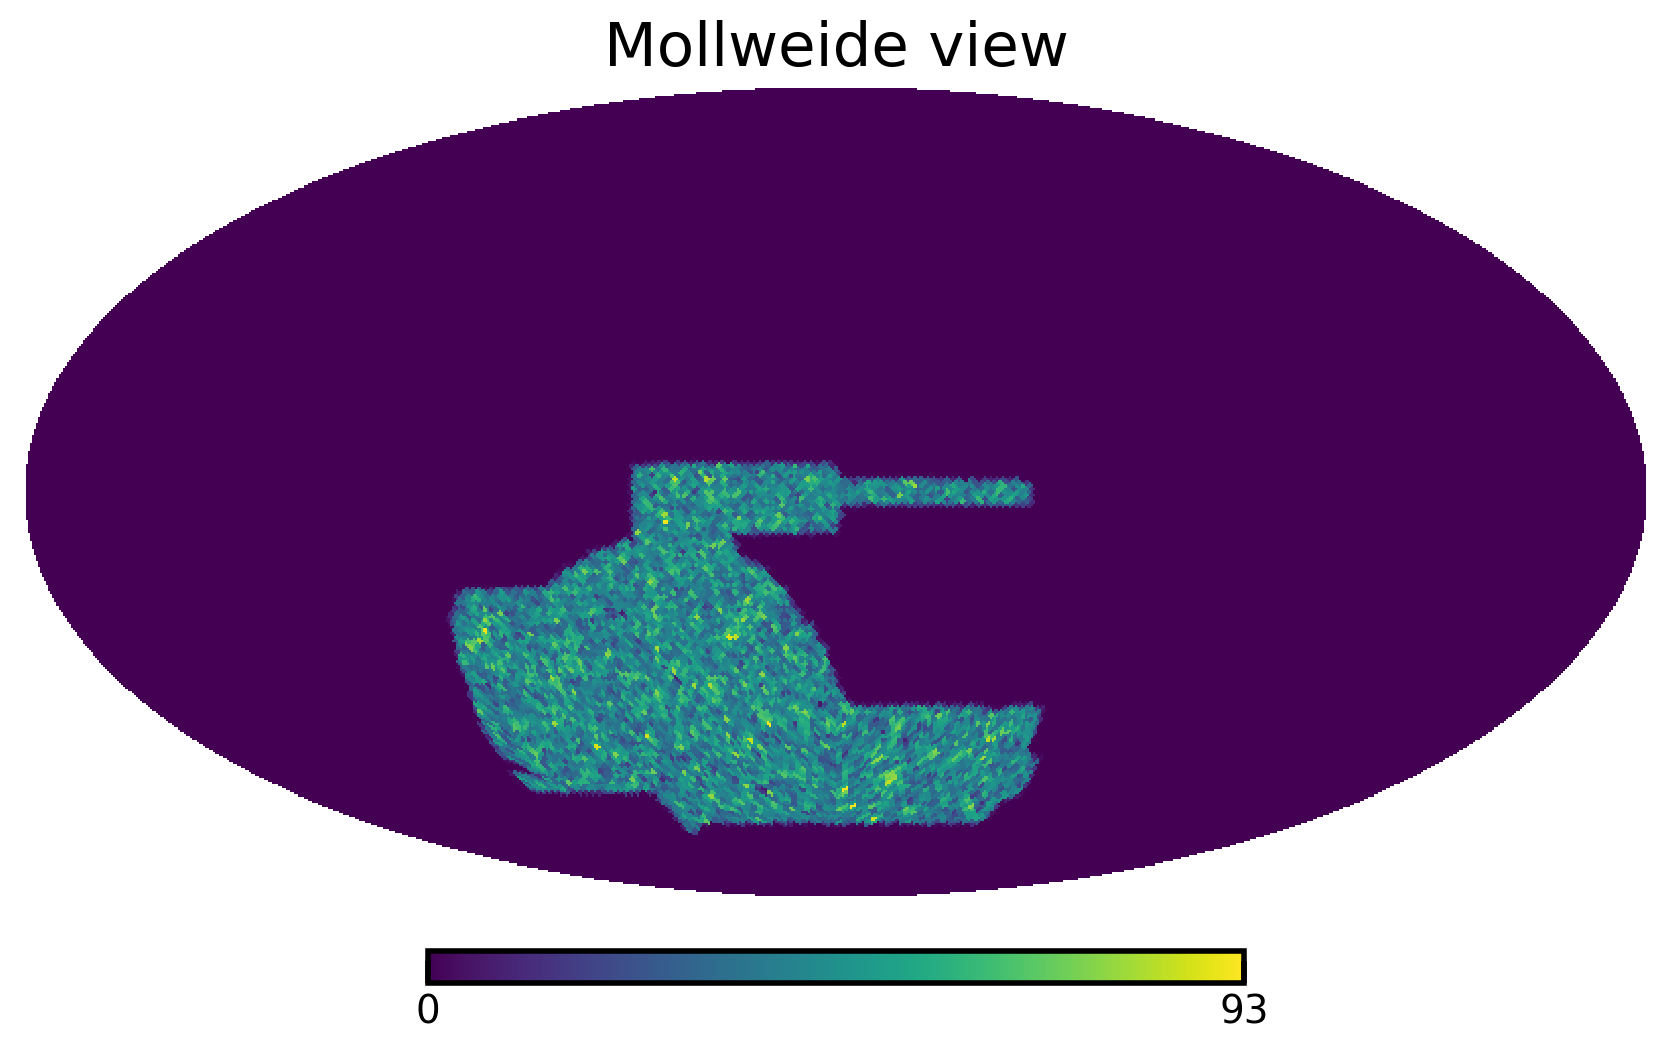

In [35]:
# mock healpix map
hpxmap = makeHealpixMap(data['ra'], data['dec'], nside=64)
hp.mollview(hpxmap)

# Generate Mock Randoms

To create uniform sky distributed objects you need to generate random number on the unit sphere. \
https://stackoverflow.com/questions/33976911/generate-a-random-sample-of-points-distributed-on-the-surface-of-a-unit-sphere

### Unit Sphere Random Number Generator

Uses polar coordinates then normalize by the norm of the vector to create an unit vector.


In [36]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

Npoints = int(100*data.csize)
xi, yi, zi = sample_spherical(Npoints)
pos = np.vstack([xi,yi,zi]).T

In [38]:
source = RandomCatalog(pos.shape[0], seed=42)
source['Position'] = source.make_column(pos)
source['Position']

dask.array<array, shape=(26362400, 3), dtype=float64, chunksize=(100000, 3), chunktype=numpy.ndarray>

In [39]:
from nbodykit.transform import CartesianToSky, CartesianToEquatorial

# project onto the sphere

_posSky = CartesianToEquatorial(source['Position'],observer=[0., 0., 0.], frame='icrs')
source['ra'] = np.where(_posSky[0]<0, _posSky[0]+360, _posSky[0])
source['dec'] = _posSky[1]

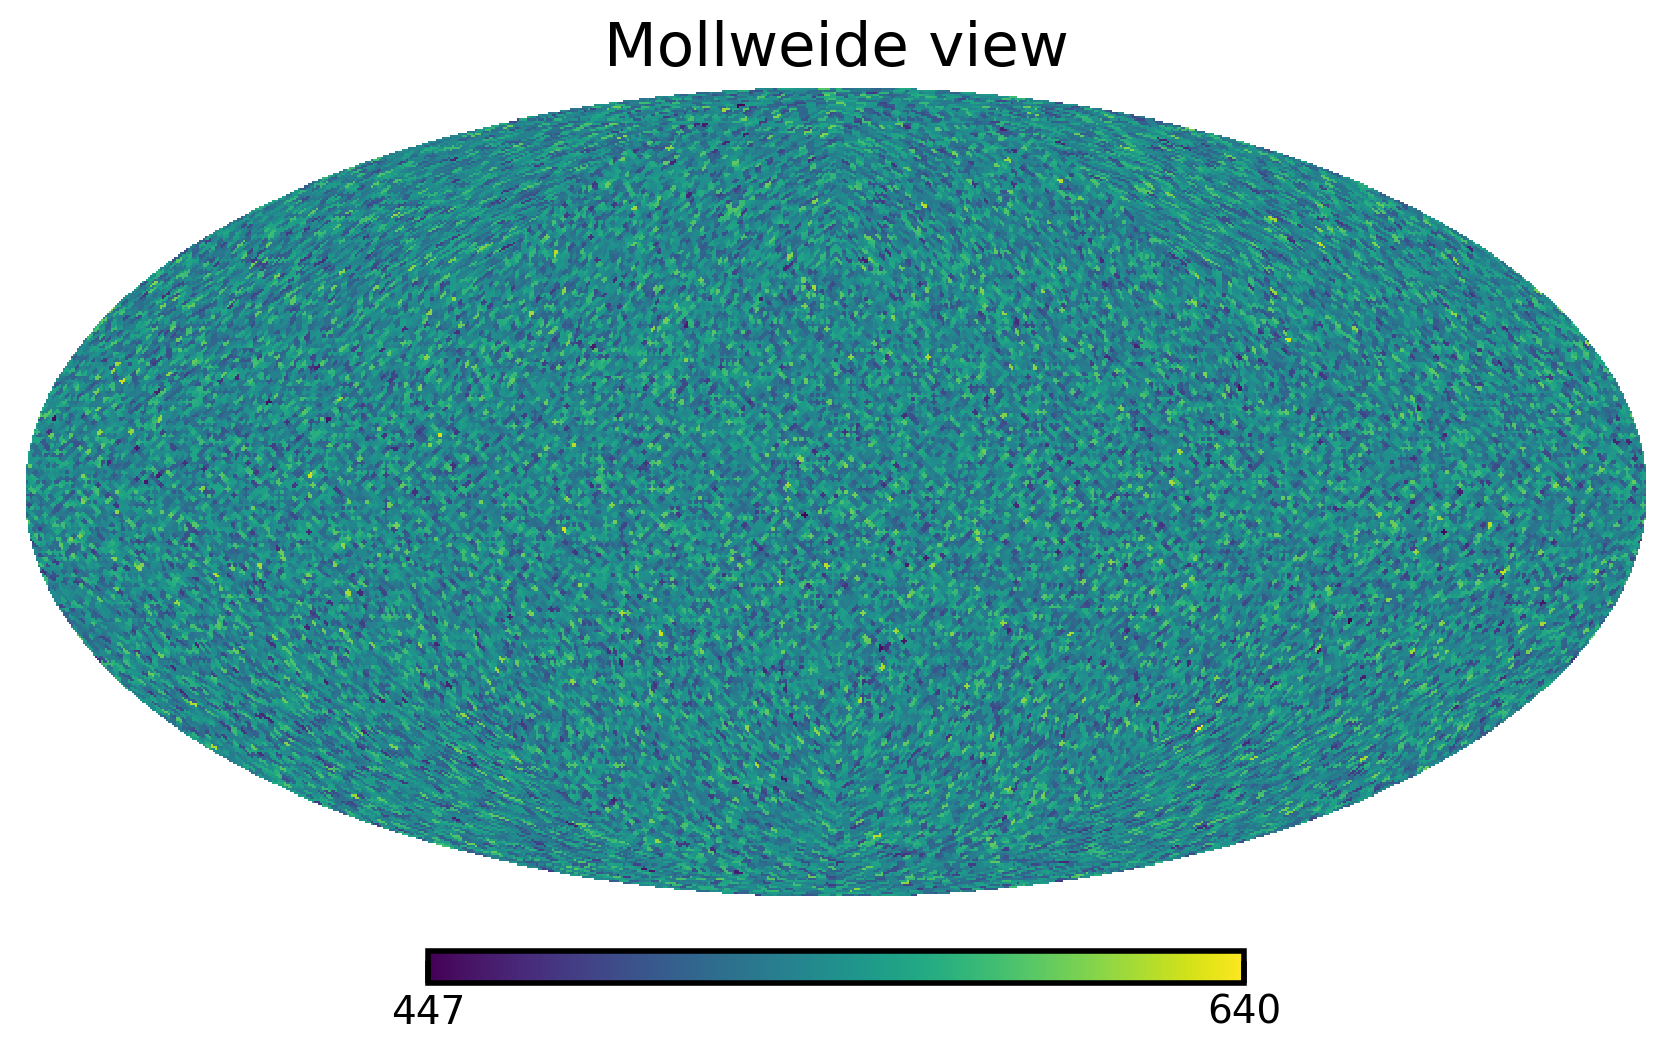

In [40]:
hm = makeHealpixMap(np.array(source['ra']), np.array(source['dec']),nside=64)
hp.mollview(hm)

In [41]:
hpx_coords = radec_to_pix(np.array(source['ra']), np.array(source['dec']),nside=64)
source['hpx_mask'] = (hpxmap[hpx_coords]!=0)

des_footprint = source['hpx_mask']
randoms = source[des_footprint]
randoms

RandomCatalog(size=3408385, seed=42)

optimizing parameters of Albers to minimize stdDistortion
best objective 0.048285 at Albers(28.410888332296725,-34.94864308027253,-58.03233570640144,-11.184045092050267)


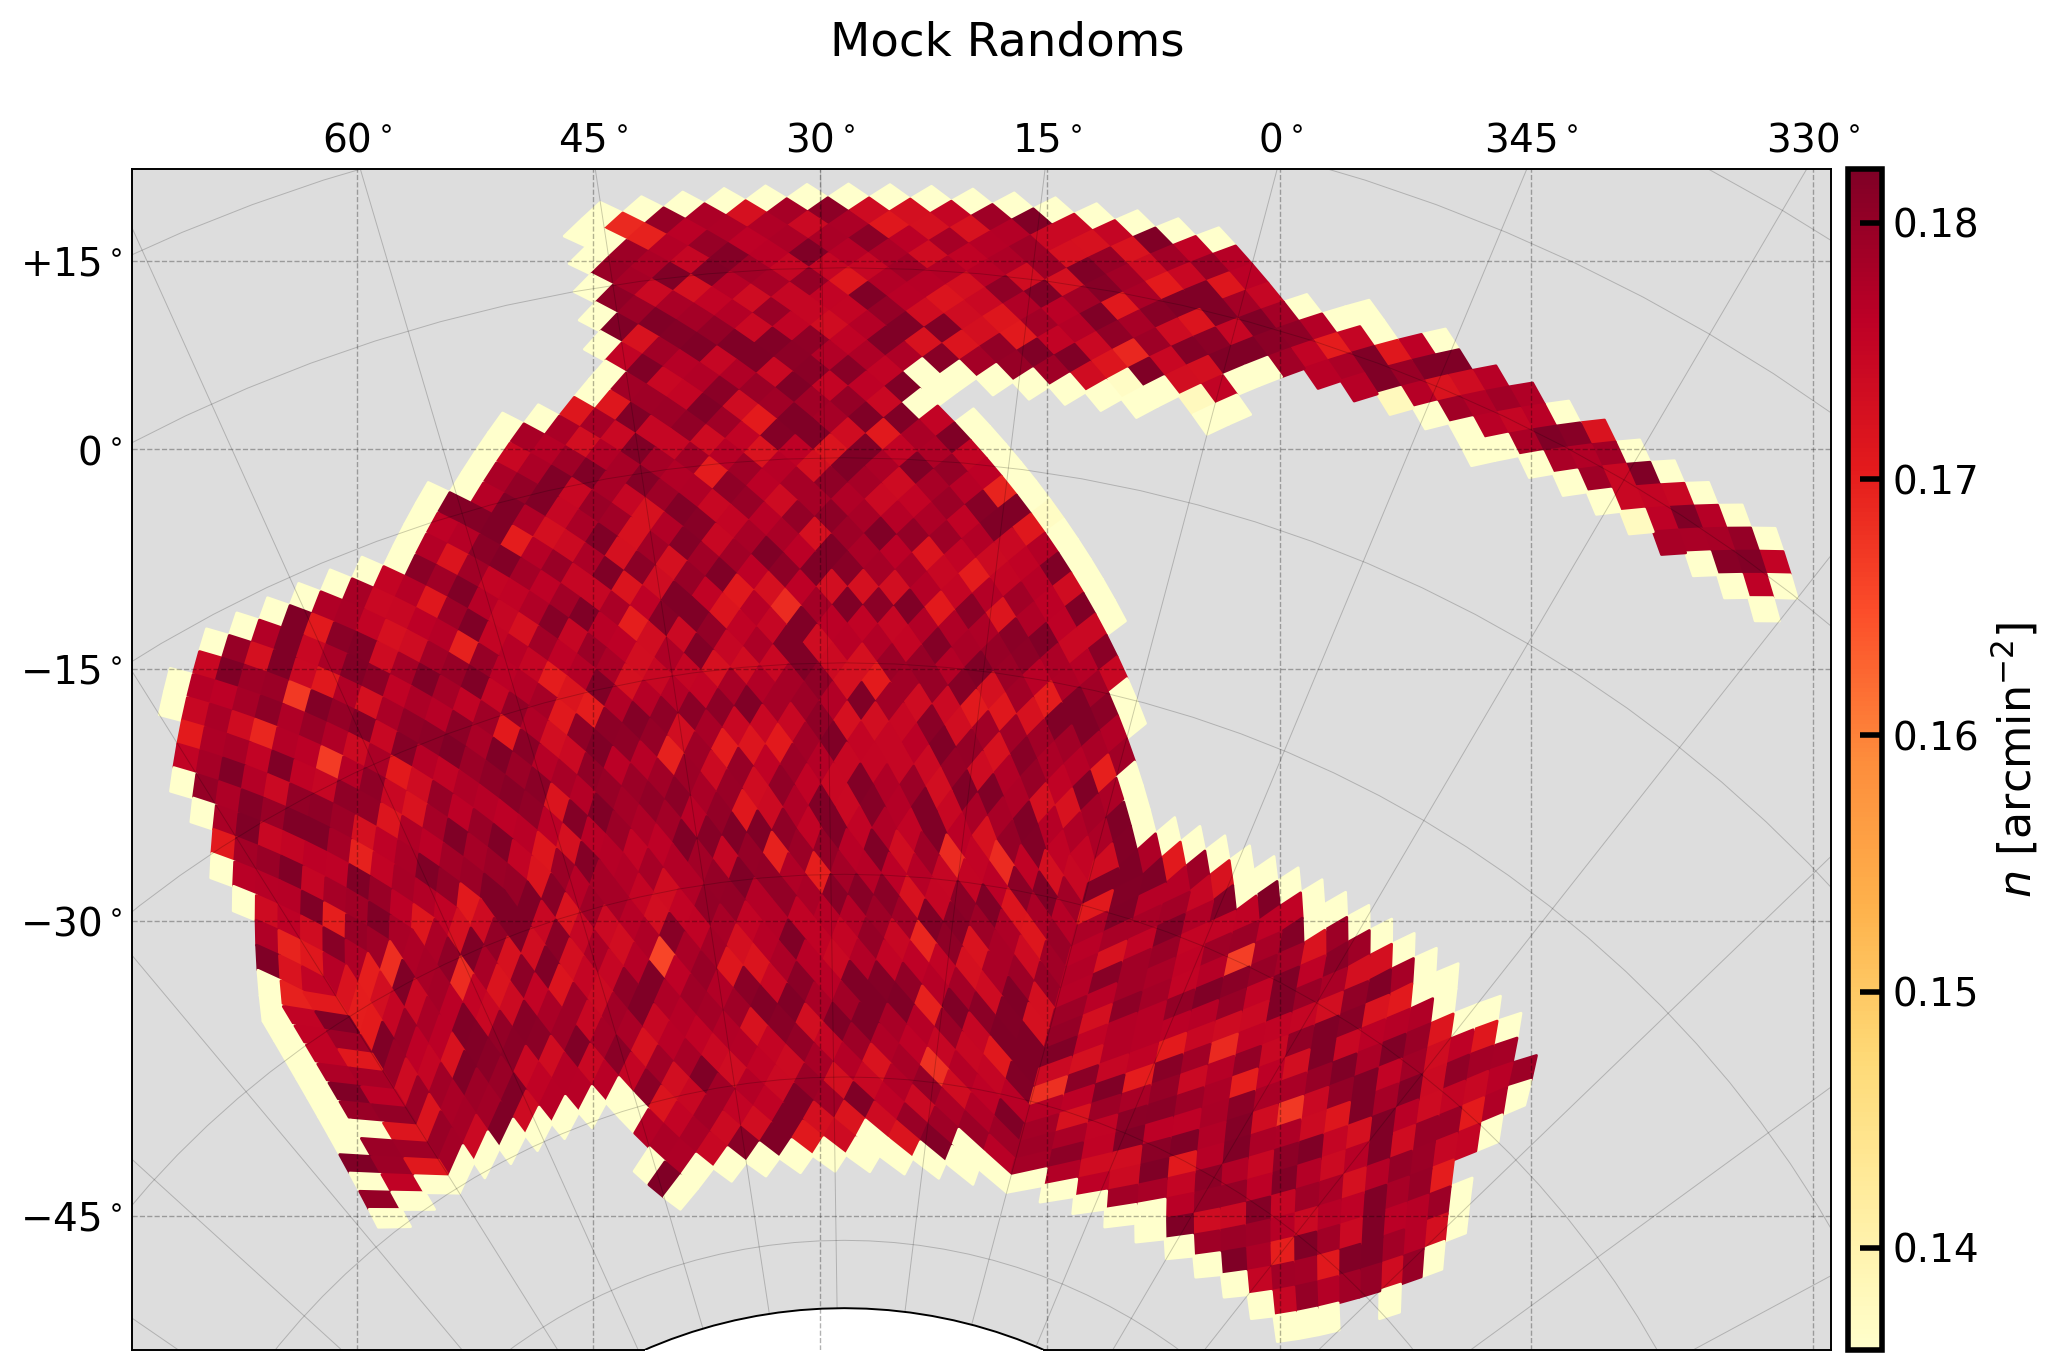

In [42]:
plot_hpx_density(np.array(randoms['ra']), np.array(randoms['dec']),title='Mock Randoms')


optimizing parameters of Albers to minimize stdDistortion
best objective 0.046359 at Albers(28.290245082199487,-35.90210530386679,-57.1495802278479,-11.342859189737032)


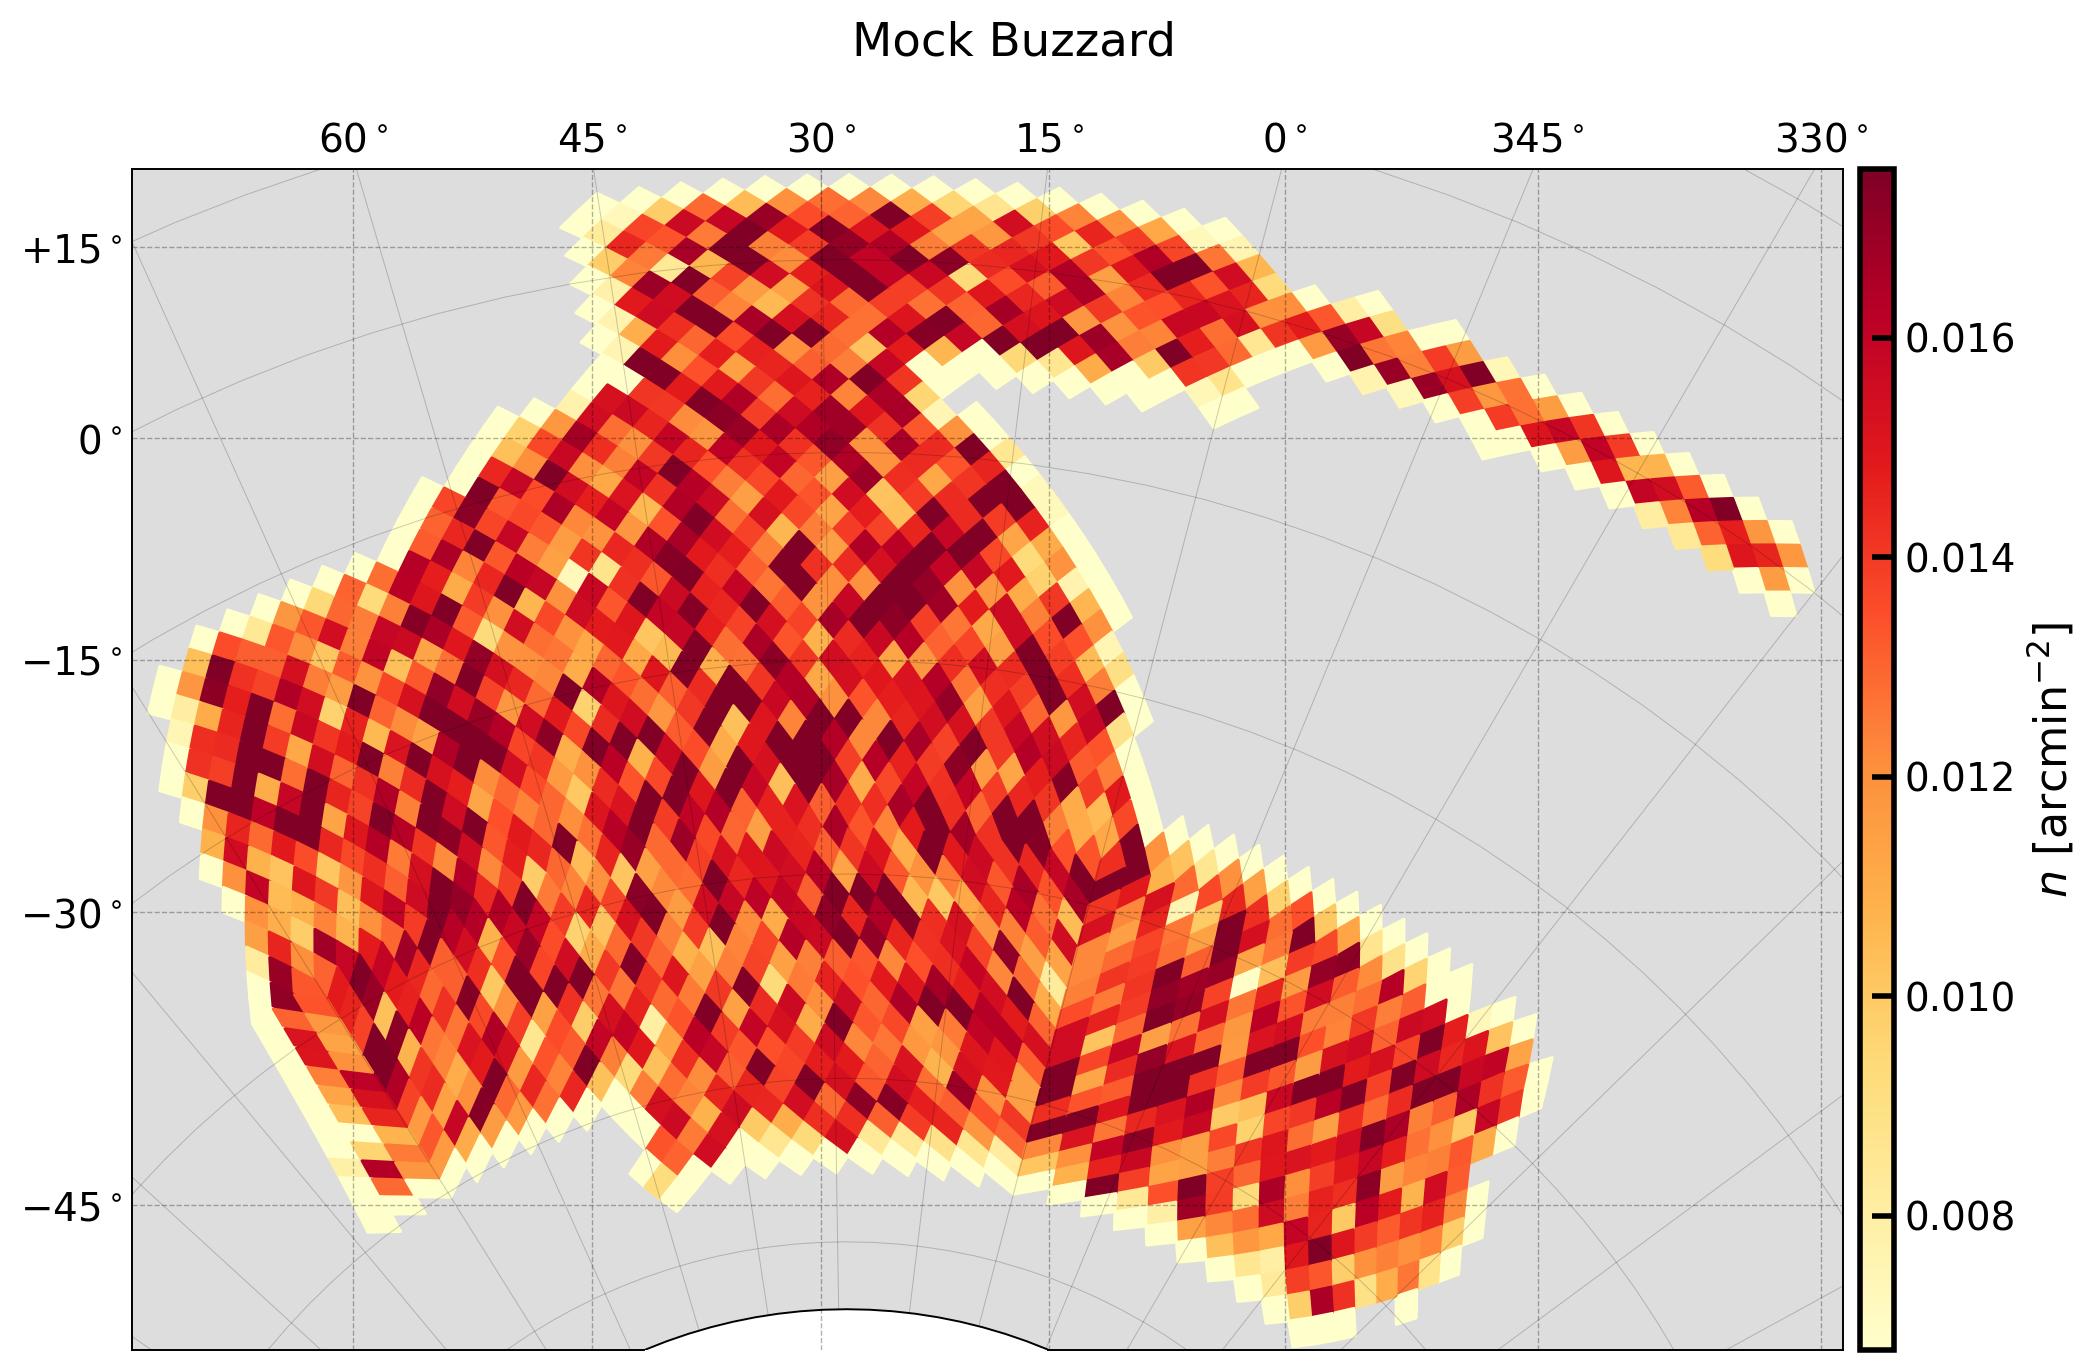

In [43]:
plot_hpx_density(np.array(data['ra']), np.array(data['dec']),title='Mock Buzzard')


## Survey Selection: $n(z)$

In [44]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value

# compute n(z) from the randoms
zhist = RedshiftHistogram(data, FSKY, cosmo, redshift='z')
# add n(z) from randoms to the FKP source
nofz = InterpolatedUnivariateSpline(zhist.bin_centers, zhist.nbar)

In [45]:

# # add Cartesian position column
# data['Position'] = transform.SkyToCartesian(data['ra'], data['dec'], data['z'], cosmo=cosmo)
# rany3['Position'] = transform.SkyToCartesian(randoms['ra'], randoms['dec'], randoms['z'], cosmo=cosmo)

Now, I will paint a new redshift distribution on the mock.

In [46]:
nofz_volume = InterpolatedUnivariateSpline(zhist.bin_centers, zhist.nbar*zhist.dV)

In [47]:
zvec = np.random.uniform(0.2, 0.65, randoms.csize)
pz = nofz_volume(zvec)
pz = np.where(pz<0., 0., pz)
# volume = comov_

# indices = np.arange(zvec.size,dtype=int)
znew = np.random.choice(zvec, p=pz/np.sum(pz), size=zvec.size)
znew = np.where((znew>0.33)&(znew<0.37), np.nan, znew)

# solving the nans
isnan = np.isnan(znew)
znew[isnan] = np.random.choice(zvec, p=pz/np.sum(pz), size=np.count_nonzero(isnan))

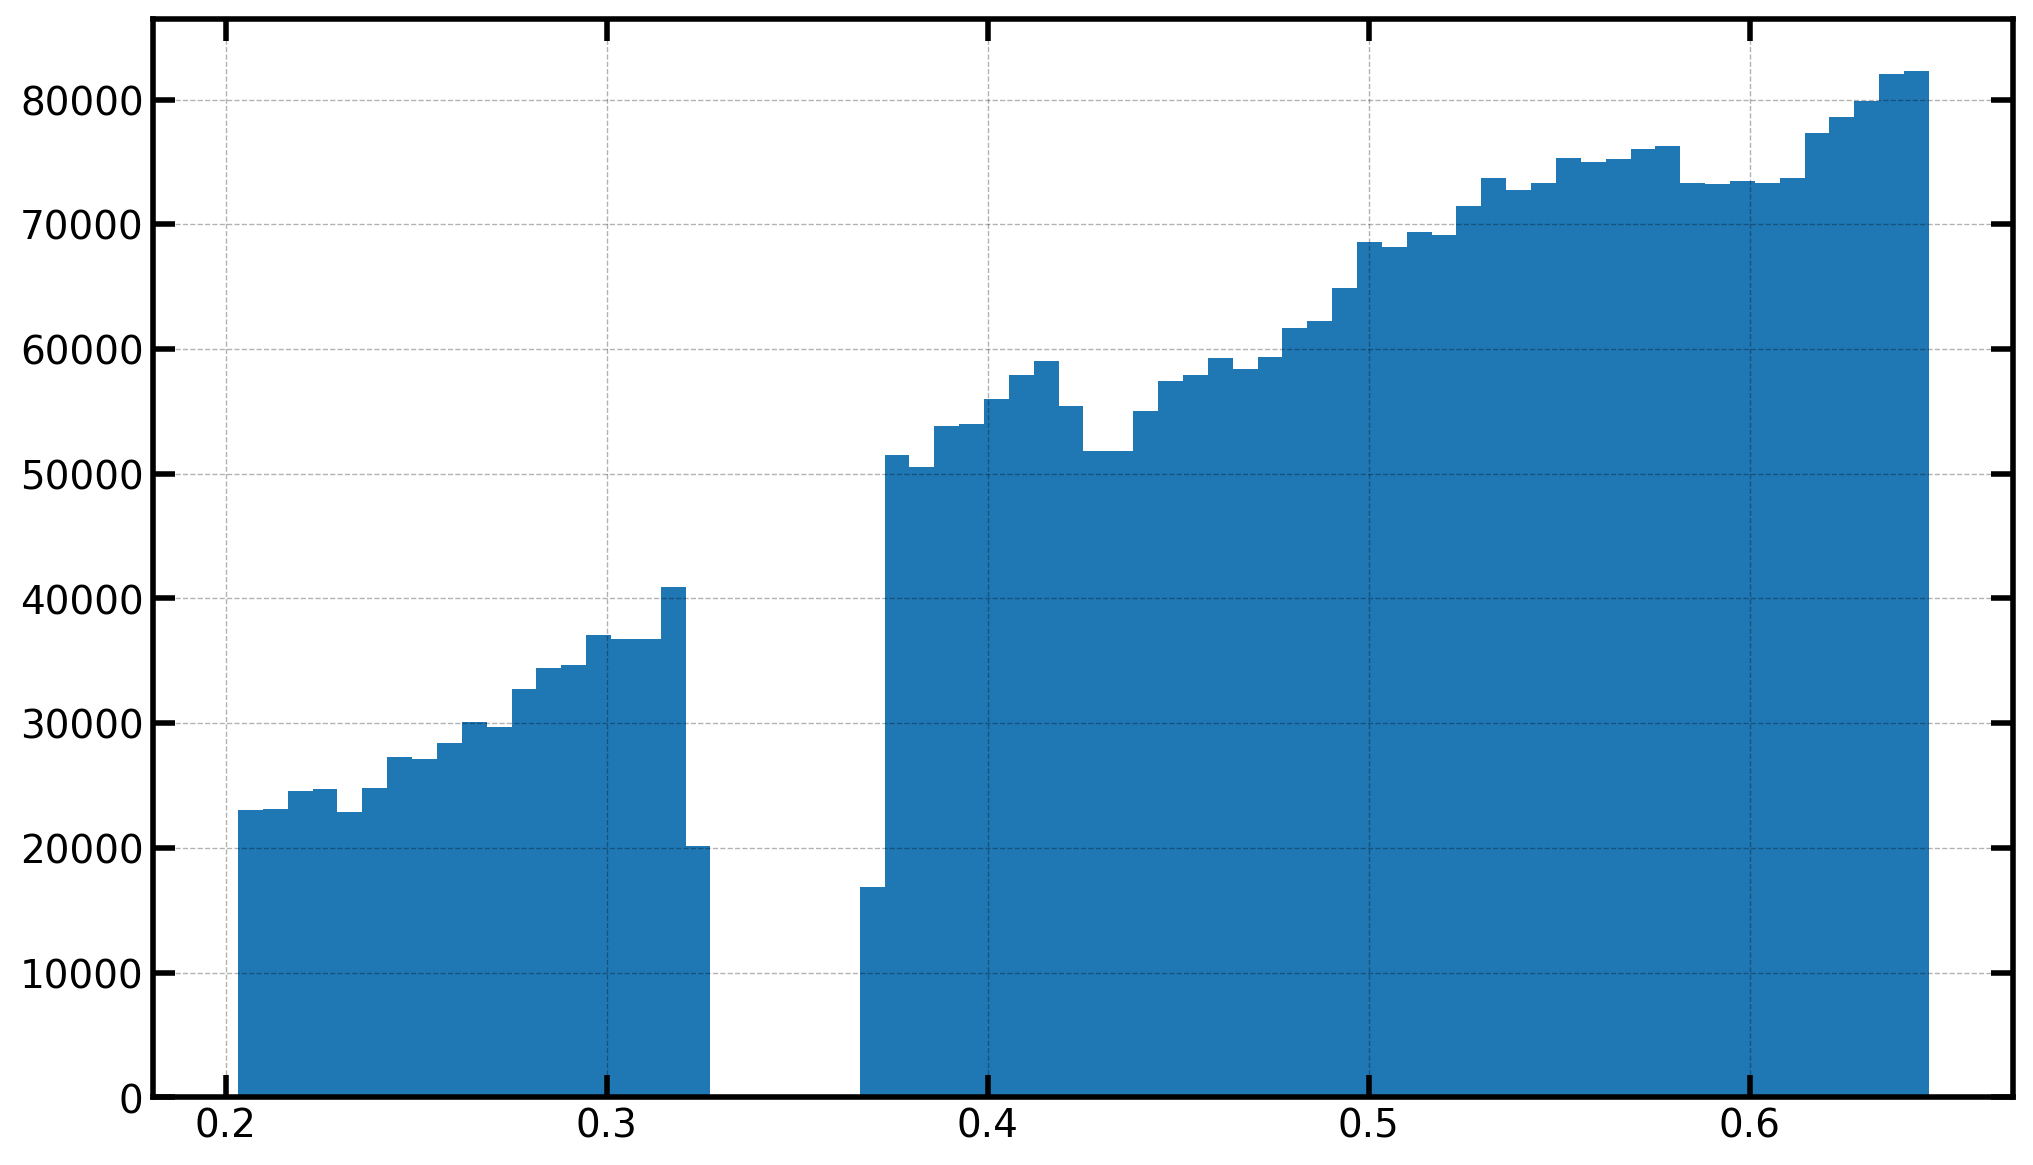

In [48]:
_ = plt.hist(znew,zhist.bin_centers)

In [49]:
randoms['z'] = znew

Text(0, 0.5, '$n(z)$ $[h^{3} \\mathrm{Mpc}^{-3}]$')

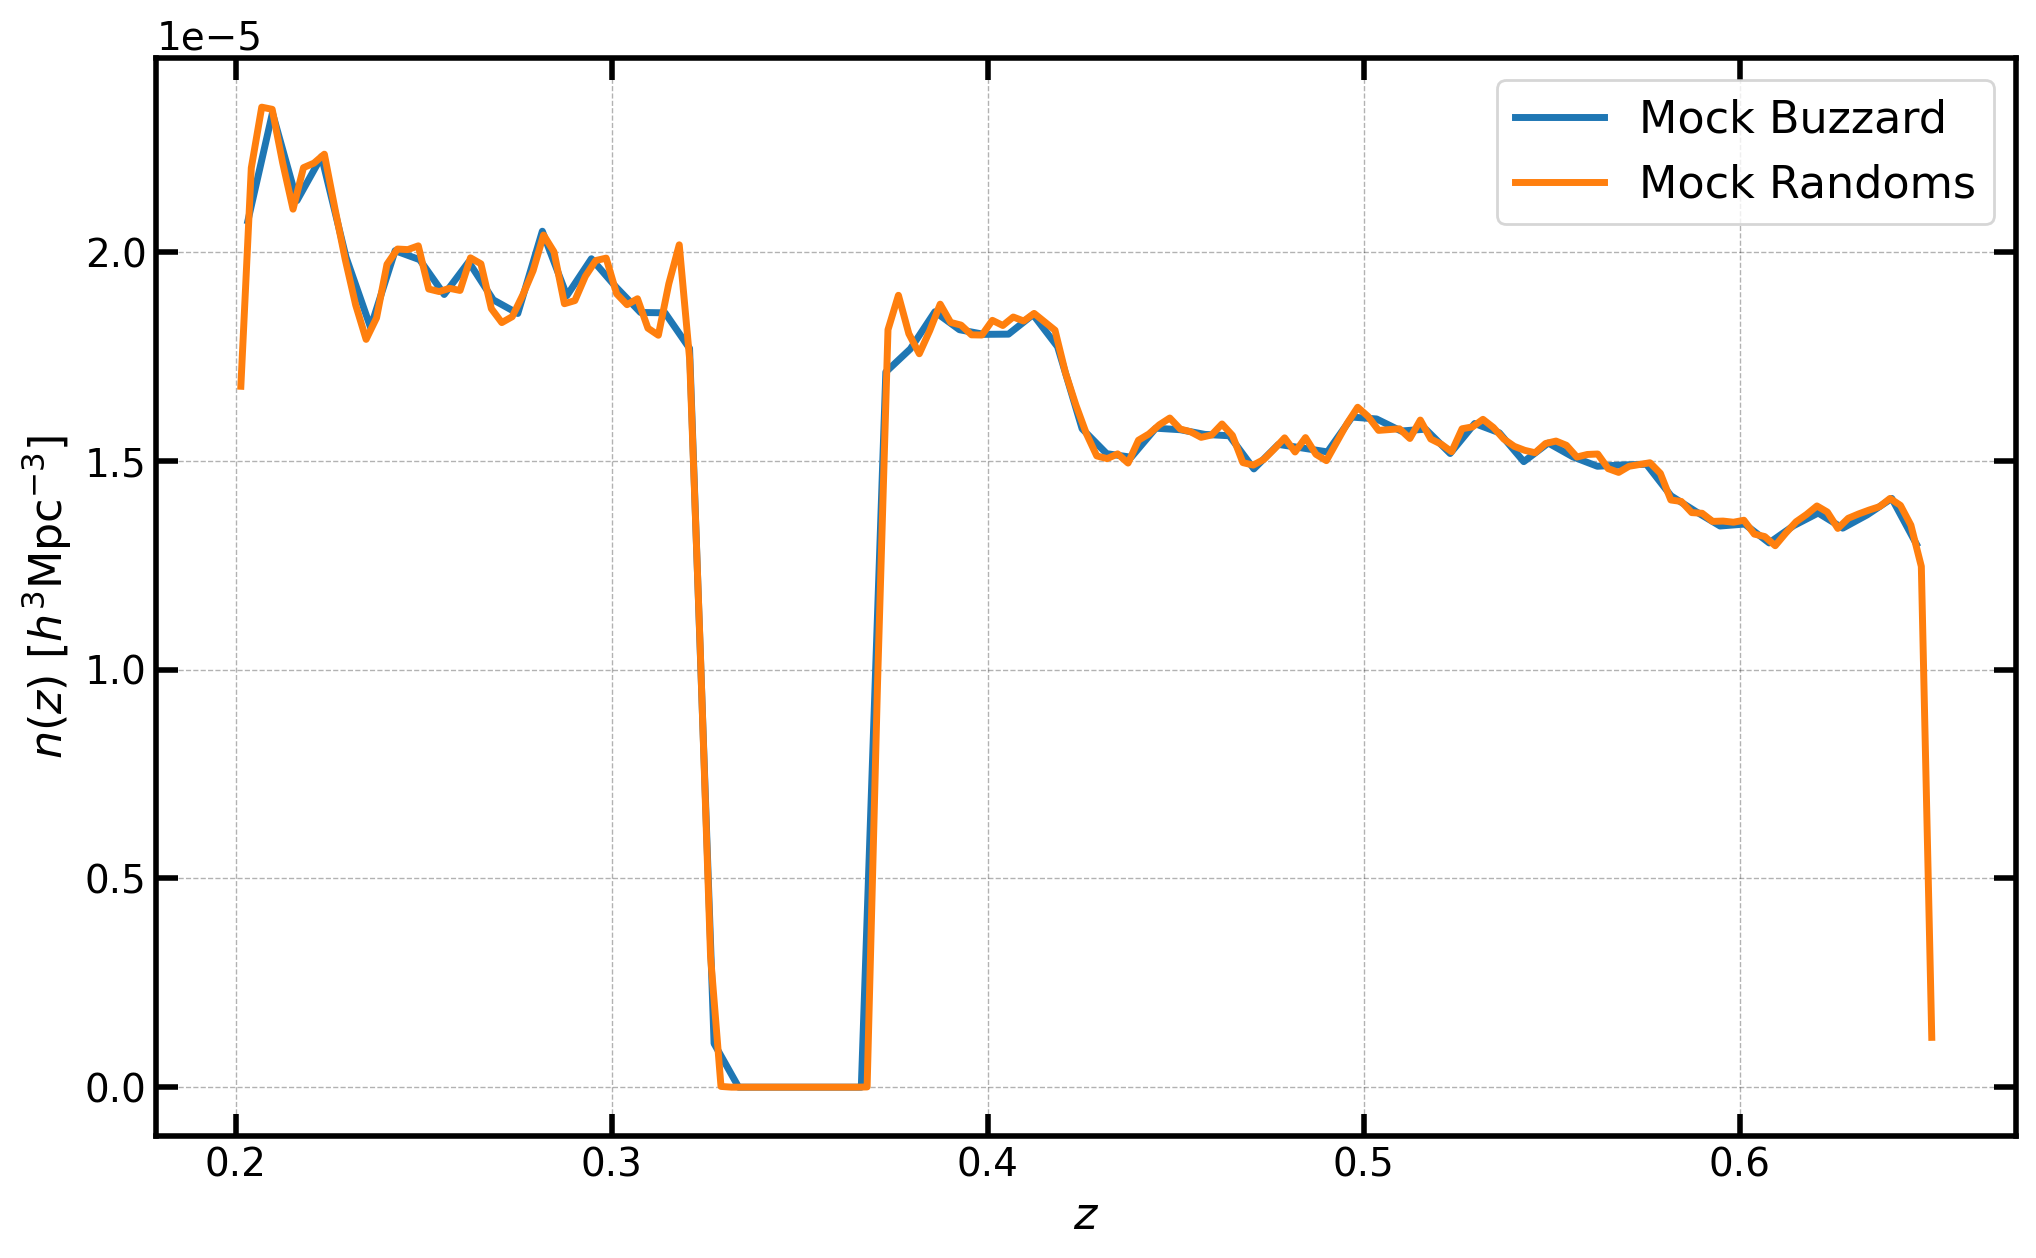

In [50]:
# the sky fraction, used to compute volume in n(z)
FSKY = 1. # a made-up value
# re-normalize to the total size of the data catalog
alpha = 1.0 * data.csize / randoms.csize

zhist_ran2 = RedshiftHistogram(randoms, FSKY, cosmo, redshift='z')
nofz_ran = InterpolatedUnivariateSpline(zhist_ran2.bin_centers, alpha*zhist_ran2.nbar)

# plot
plt.plot(zhist.bin_centers,  zhist.nbar,label='Mock Buzzard')
plt.plot(zhist_ran2.bin_centers,  alpha*zhist_ran2.nbar,label='Mock Randoms')
# plt.plot(zhist_ran.bin_centers,  alpha*zhist_ran.nbar,label='DES Y3 Randoms')
plt.legend()
plt.xlabel(r"$z$", fontsize=16)
plt.ylabel(r"$n(z)$ $[h^{3} \mathrm{Mpc}^{-3}]$", fontsize=16)

Note: we should apply the survey area mask on the gaps of the halo catalog. Or fill the gaps on the randoms catalog.

In [51]:
from astropy.table import Table

rand = Table()
rand['ra'] = np.array(randoms['ra'])
rand['dec'] = np.array(randoms['dec'])
rand['z'] = np.array(randoms['z'])
# rand['weight'] = np.array(randoms['weight'])
# rand['avg_lambdaout'] = np.array(randoms['avg_lambdaout'])

rand.write(floc.mock_randoms_fname, overwrite=True)
print('Saved file: %s'%floc.mock_randoms_fname)

AttributeError: 'FileLocs' object has no attribute 'mock_randoms_fname'